In [1]:
library(ggplot2)
library(reshape2)
library(rstatix)
library(dplyr)
library(tidyverse)
library(RColorBrewer)
library(ARTool)
library(readxl) 
library(ggsignif) 
library(seewave)
library(gsignal)
library(spectral)
library(onion)
library(fANCOVA) 
library(purrr)
library(inflection)
library(ggpubr)
library(ggrepel)

# Function toround whole data frames (useful for reporting later)
round_df <- function(df, digits = 3) {
  nums <- vapply(df, is.numeric, FUN.VALUE = logical(1))
  df[,nums] <- round(df[,nums], digits = digits)
  (df)
}

# nice colors
cbPalette <- c("tomato1","steelblue2","#EEC900", "gray70","olivedrab4","lightpink4","darkorange2",'#D55E00')


Attache Paket: 'rstatix'


Das folgende Objekt ist maskiert 'package:stats':

    filter



Attache Paket: 'dplyr'


Die folgenden Objekte sind maskiert von 'package:stats':

    filter, lag


Die folgenden Objekte sind maskiert von 'package:base':

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
✔ readr     2.1.4     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks rstatix::filter(), stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attache Paket: 'seewave'


Das folgende Objekt ist maskiert 'package:lubridate':

    duration


Das folgende Objekt ist ma

In [2]:
# We want to read all the logs in data folder
file_list <- list.files("data_upload/", full.names = TRUE) 
data <- NULL 
print(file_list)

for (file in file_list){ 
  df_tmp <- read.csv(file, sep=";", dec=",", header=F)
  print(file)
  df_tmp$file <- file  
  if (file != "data/desktop.ini") {
    data <- rbind(data, df_tmp)
  }
}

colnames(data) <- c("Time","biceps","triceps","upperleg","calf","SubjectID","condition","lightSwitch","file")

# Set all factors  
data[c('Muscle', 'Modality', 'Timing', 'Trial')] <- str_split_fixed(data$condition, '-', 4) 
data$SubjectID <- as.factor(data$SubjectID)
data$Muscle <- as.factor(data$Muscle)
data$Modality <- as.factor(data$Modality)
data$Timing <- as.factor(data$Timing)
data$Trial <- as.factor(data$Trial)
data$ID <- data$file <- data$condition <- data$Random <- NULL
data$lightSwitch <- as.factor(data$lightSwitch)  

# delete duplicate time slots
data <- data[!duplicated(data$Time), ]

# counter check levels
levels(data$Trial)
levels(data$Modality)
levels(data$Timing)
levels(data$SubjectID)
levels(data$Muscle)

# lights on
data <- data[data$lightSwitch == "on",] 

# getting duration through start time of each trial
trialTime <- aggregate(Time ~ Muscle + Modality + Timing + Trial + SubjectID, data, min)
trialTime <- do.call(data.frame, trialTime)                    
trialTime$startTime <- trialTime$Time
trialTime$Time <- NULL
data <- merge(data, trialTime)

# getting experimental trial time through start time of each subject
experimentTime <- aggregate(Time ~ SubjectID, data, min)
experimentTime <- do.call(data.frame, experimentTime)                    
experimentTime$experimentTime <- experimentTime$Time
experimentTime$Time <- NULL
data <- merge(data, experimentTime)

data$trialTime <- data$Time - data$startTime # trial duration in nano seconds
data$experimentTime <- data$Time - data$experimentTime # experiment duration in nano seconds
data$trialTime <- data$trialTime / 1000 / 1000  
data$experimentTime <- data$experimentTime / 1000 / 1000 

# No idea what I am doing with these values
data$EMGValue <- NA 
data$EMGTKEOValue <- NA 
data <- do.call(data.frame, data) 
for (i in 1:nrow(data)) {   
  data[i, "EMGValue"] <- data[i, as.character(data[i, "Muscle"])] 
} 
data <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% mutate(minEMGValue = min(EMGValue))
data <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% mutate(maxEMGValue = max(EMGValue))

# Now we do this: https://www.researchgate.net/figure/EMG-signal-process-recommended-Green-The-raw-signal-no-treatment-was-applied-until_fig2_258344784

# Using random TKEO https://rdrr.io/cran/seewave/man/TKEO.html with y[n] = x[n]^{2/m} - (x[n-M]*x[n+M])^{1/m} (Filtration)
data <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% mutate(EMGTKEOValue = 
                                                                                   abs(as.data.frame(TKEO(EMGValue, f = 1000, channel = 1, m = 1, M = 1, plot = F, xlab = "Time (s)", ylab = "Energy"))[,2]))
# remove NAs
data <- na.omit(data)

# not interested in negative values (Rectification)
data <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% mutate(minEMGTKEOValue = abs(min(EMGTKEOValue)))
data <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% mutate(maxEMGTKEOValue = max(EMGTKEOValue))

# normalize EMG and TKEO processed signal again
data$EMGValueNormalized <- (data$EMGValue - data$minEMGValue) / (data$maxEMGValue - data$minEMGValue)
data$EMGTKEOValueNormalized <- (data$EMGTKEOValue - data$minEMGTKEOValue) / (data$maxEMGTKEOValue - data$minEMGTKEOValue)


 [1] "data_upload/106_RawData_638212279346974801.csv"
 [2] "data_upload/107_RawData_638212398133542847.csv"
 [3] "data_upload/108_RawData_638213016789855139.csv"
 [4] "data_upload/109_RawData_638240662136220960.csv"
 [5] "data_upload/180_RawData_638243256220077257.csv"
 [6] "data_upload/182_RawData_638245845076551816.csv"
 [7] "data_upload/184_RawData_638246084791835915.csv"
 [8] "data_upload/186_RawData_638258809433667245.csv"
 [9] "data_upload/187_RawData_638258940018981630.csv"
[10] "data_upload/188_RawData_638259652938366600.csv"
[11] "data_upload/189_RawData_638259864144917902.csv"
[12] "data_upload/190_RawData_638264078947643465.csv"
[13] "data_upload/191_RawData_638264997626273428.csv"
[14] "data_upload/192_RawData_638270048981419009.csv"
[15] "data_upload/193_RawData_638270147733473558.csv"
[16] "data_upload/194_RawData_638270280944689015.csv"
[1] "data_upload/106_RawData_638212279346974801.csv"
[1] "data_upload/107_RawData_638212398133542847.csv"
[1] "data_upload/108_RawData_6

[1] "1" "2"

[1] "EMS"       "nothing"   "Vibration" "Visual"

[1] "11" "13" "3"  "5"  "7"  "9"

[1] "106" "107" "108" "109" "111" "182" "184" "186" "187" "188" "189" "190"
[13] "191" "192" "193" "194"

[1] "biceps"   "calf"     "triceps"  "upperleg"

Warning message:
"There were 128 warnings in `mutate()`.
The first warning was:
ℹ In argument: `EMGTKEOValue = abs(...)`.
ℹ In group 673: `SubjectID = 109`, `Muscle = triceps`, `Modality = EMS`, `Timing = 11`, `Trial = 1`.
Caused by warning in `c(wave[-(1:M)], rep(NA, M)) * c(rep(NA, M), wave[1:(length(wave) - M)])`:
! NAs durch Ganzzahlüberlauf erzeugt
ℹ Run `dplyr::last_dplyr_warnings()` to see the 127 remaining warnings."


In [3]:
head(data)

SubjectID,Muscle,Modality,Timing,Trial,Time,biceps,triceps,upperleg,calf,⋯,experimentTime,trialTime,EMGValue,EMGTKEOValue,minEMGValue,maxEMGValue,minEMGTKEOValue,maxEMGTKEOValue,EMGValueNormalized,EMGTKEOValueNormalized
<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
106,biceps,EMS,11,1,6.382124e+17,32980,32839,32663,30957,⋯,35049.23,0.009984,32980,1417678,12852,45327,18077,974932335,0.6197998,0.001435614
106,biceps,EMS,11,1,6.382124e+17,32958,32880,32917,30798,⋯,35049.24,0.019968,32958,5277284,12852,45327,18077,974932335,0.6191224,0.005394533
106,biceps,EMS,11,1,6.382124e+17,32776,32871,32939,31135,⋯,35049.25,0.030080,32776,6624392,12852,45327,18077,974932335,0.6135181,0.006776304
106,biceps,EMS,11,1,6.382124e+17,32796,32838,33047,31381,⋯,35049.33,0.110080,32796,3212448,12852,45327,18077,974932335,0.6141339,0.003276566
106,biceps,EMS,11,1,6.382124e+17,32718,32927,32999,31965,⋯,35049.34,0.120064,32718,6520320,12852,45327,18077,974932335,0.6117321,0.006669554
106,biceps,EMS,11,1,6.382124e+17,32839,32839,32855,32450,⋯,35049.44,0.220032,32839,18077,12852,45327,18077,974932335,0.6154580,0.000000000


In [4]:
# Compute the moving root mean square (RMS) of the input signal.
data <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% mutate(EMGSmoothedValue =  
    predict(loess(EMGTKEOValueNormalized  ~ trialTime, 
                  span = loess.as(EMGTKEOValueNormalized, trialTime, degree = 1, criterion = c("aicc", "gcv")[2], family = c("gaussian", "symmetric")[2], user.span = NULL, plot = F)$pars$span),
            trialTime))

data <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% mutate(minEMGSmoothedValue = min(EMGSmoothedValue))
data <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% mutate(maxEMGSmoothedValue = max(EMGSmoothedValue))

data$EMGSmoothedValueNormalized <- (data$EMGSmoothedValue - data$minEMGSmoothedValue) / (data$maxEMGSmoothedValue - data$minEMGSmoothedValue)
head(data)
 
# EMGSmoothedValueNormalized = normalized EMGSmoothedValue
# EMGSmoothedValue = loess(EMGTKEOValueNormalized)
# EMGTKEOValueNormalized = tkeo(EMGValue)
# plot <- ggplot(data[data$SubjectID == "111" & data$Muscle == "calf" & data$Modality == "nothing" & data$Timing == "11" & data$Trial == "1",],
#                aes(x=trialTime, y=EMGSmoothedValueNormalized)) + geom_line(color="darkgreen") + 
#                 geom_line(aes(y=EMGTKEOValueNormalized), color="darkred")  + geom_line(aes(y=EMGSmoothedValue), color="red")  
# 
# options(repr.plot.width = 12, repr.plot.height = 4) 
# plot
# 
# plot <- ggplot(data[data$SubjectID == "111" & data$Muscle == "biceps" & data$Modality == "nothing" & data$Timing == "11" & data$Trial == "1",],
#                aes(x=trialTime, y=EMGSmoothedValueNormalized)) + geom_line(color="darkgreen") + 
#                 geom_line(aes(y=EMGTKEOValueNormalized), color="darkred")  + geom_line(aes(y=EMGSmoothedValue), color="red")  
# options(repr.plot.width = 12, repr.plot.height = 4) 
# plot
#  
# 
# plot <- ggplot(data[data$SubjectID == "111" & data$Muscle == "calf" & data$Modality == "nothing" & data$Timing == "11" & data$Trial == "1",],
#                aes(x=trialTime, y=EMGSmoothedValueNormalized)) + geom_line(color="darkgreen")
# options(repr.plot.width = 12, repr.plot.height = 4)
# plot

# only one trial
#data[data$SubjectID == "104" & data$Muscle == "calf" & data$Modality == "nothing" & data$Timing == "11" & data$Trial == "1",]

# muscle: biceps, calf, triceps, upperleg
# modality: nothing, Visual, EMS, Vibration
# timing: 11, 13, 3, 5, 7, 9
# trial: 1, 2

num_trials <- unique(data$Trial)
num_timings <- unique(data$Timing)
num_modalities <- unique(data$Modality)
num_muscles <- unique(data$Muscle)
num_participants <- unique(data$SubjectID)

SubjectID,Muscle,Modality,Timing,Trial,Time,biceps,triceps,upperleg,calf,⋯,minEMGValue,maxEMGValue,minEMGTKEOValue,maxEMGTKEOValue,EMGValueNormalized,EMGTKEOValueNormalized,EMGSmoothedValue,minEMGSmoothedValue,maxEMGSmoothedValue,EMGSmoothedValueNormalized
<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
106,biceps,EMS,11,1,6.382124e+17,32980,32839,32663,30957,⋯,12852,45327,18077,974932335,0.6197998,0.001435614,-0.005337102,-0.005337102,0.1257177,0.000000000
106,biceps,EMS,11,1,6.382124e+17,32958,32880,32917,30798,⋯,12852,45327,18077,974932335,0.6191224,0.005394533,-0.004939835,-0.005337102,0.1257177,0.003031302
106,biceps,EMS,11,1,6.382124e+17,32776,32871,32939,31135,⋯,12852,45327,18077,974932335,0.6135181,0.006776304,-0.004538164,-0.005337102,0.1257177,0.006096213
106,biceps,EMS,11,1,6.382124e+17,32796,32838,33047,31381,⋯,12852,45327,18077,974932335,0.6141339,0.003276566,-0.001389821,-0.005337102,0.1257177,0.030119317
106,biceps,EMS,11,1,6.382124e+17,32718,32927,32999,31965,⋯,12852,45327,18077,974932335,0.6117321,0.006669554,-0.001001200,-0.005337102,0.1257177,0.033084648
106,biceps,EMS,11,1,6.382124e+17,32839,32839,32855,32450,⋯,12852,45327,18077,974932335,0.6154580,0.000000000,0.002822986,-0.005337102,0.1257177,0.062264701


In [5]:
findBulgeStart <- function(x, y){
    cc <- check_curve(x, y) 
    ipbede <- bede(x, y, cc$index)
    #ipbede <- ifelse(!is.na(ipbede), ipbede, 20)
    return(as.numeric(ipbede$iplast))
}

timesPerSubjectWithTimings <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% 
    summarize(ipbede = findBulgeStart(trialTime, EMGSmoothedValueNormalized),
              .groups = 'drop')

timesPerSubjectWithTimings <- na.omit(timesPerSubjectWithTimings)

timesPerSubject <- timesPerSubjectWithTimings %>% group_by(SubjectID, Muscle, Modality) %>% 
    summarize(RT = mean(ipbede),
              RTmin = min(ipbede),
              RTmax = max(ipbede),
              .groups = 'drop')  

head(timesPerSubject)

SubjectID,Muscle,Modality,RT,RTmin,RTmax
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
106,biceps,EMS,10.448584,6.765120,12.91674
106,biceps,nothing,8.843001,3.945856,16.22035
106,biceps,Vibration,9.347045,5.442112,13.12422
106,biceps,Visual,9.131127,5.492160,11.91373
106,calf,EMS,8.263387,5.263872,11.59738
106,calf,nothing,8.283456,5.991552,10.61882


In [6]:
round_df(timesPerSubject %>% group_by(Muscle, Modality) %>% shapiro_test(RT))

Muscle,Modality,variable,statistic,p
<fct>,<fct>,<chr>,<dbl>,<dbl>
biceps,EMS,RT,0.915,0.141
biceps,nothing,RT,0.968,0.803
biceps,Vibration,RT,0.913,0.129
biceps,Visual,RT,0.963,0.714
calf,EMS,RT,0.949,0.476
calf,nothing,RT,0.990,0.999
calf,Vibration,RT,0.946,0.432
calf,Visual,RT,0.987,0.996
triceps,EMS,RT,0.954,0.560


In [7]:
means <- timesPerSubject %>% group_by(Muscle, Modality) %>% 
    summarize(ReactionTime = mean(RT),
              ReactionTimeCI = qt(1 - (0.05 / 2), df = n()-1) * sd(RT) / sqrt(n()),
              ReactionTimeMin = mean(RTmin),
              ReactionTimeMinCI = qt(1 - (0.05 / 2), df = n()-1) * sd(RTmin) / sqrt(n()),
              ReactionTimeMax = mean(RTmax),
              ReactionTimeMaxCI = qt(1 - (0.05 / 2), df = n()-1) * sd(RTmax) / sqrt(n()),
              N = n(),
              .groups = 'drop')  

means

Muscle,Modality,ReactionTime,ReactionTimeCI,ReactionTimeMin,ReactionTimeMinCI,ReactionTimeMax,ReactionTimeMaxCI,N
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
biceps,EMS,9.043282,0.9838099,5.715536,1.0606567,12.77192,1.1845039,16
biceps,nothing,9.551037,0.6680228,6.248156,0.8531904,13.66148,1.3148154,16
biceps,Vibration,8.793655,0.5577294,4.652672,0.6696016,13.11629,1.3019291,16
biceps,Visual,9.318121,0.9024519,6.159440,0.7784254,13.41328,1.5100564,16
calf,EMS,7.711492,0.8309862,4.446944,0.6171252,12.78344,1.3168645,16
calf,nothing,8.831076,0.9755612,5.568712,0.8077473,13.13169,1.5020394,16
calf,Vibration,7.665328,0.8821314,4.830924,0.7935037,11.86882,1.4562635,16
calf,Visual,7.272337,0.8219604,4.620680,0.7219771,11.12863,1.2238032,16
triceps,EMS,8.588431,0.9515662,5.177048,0.8885598,12.61491,1.5311472,16


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


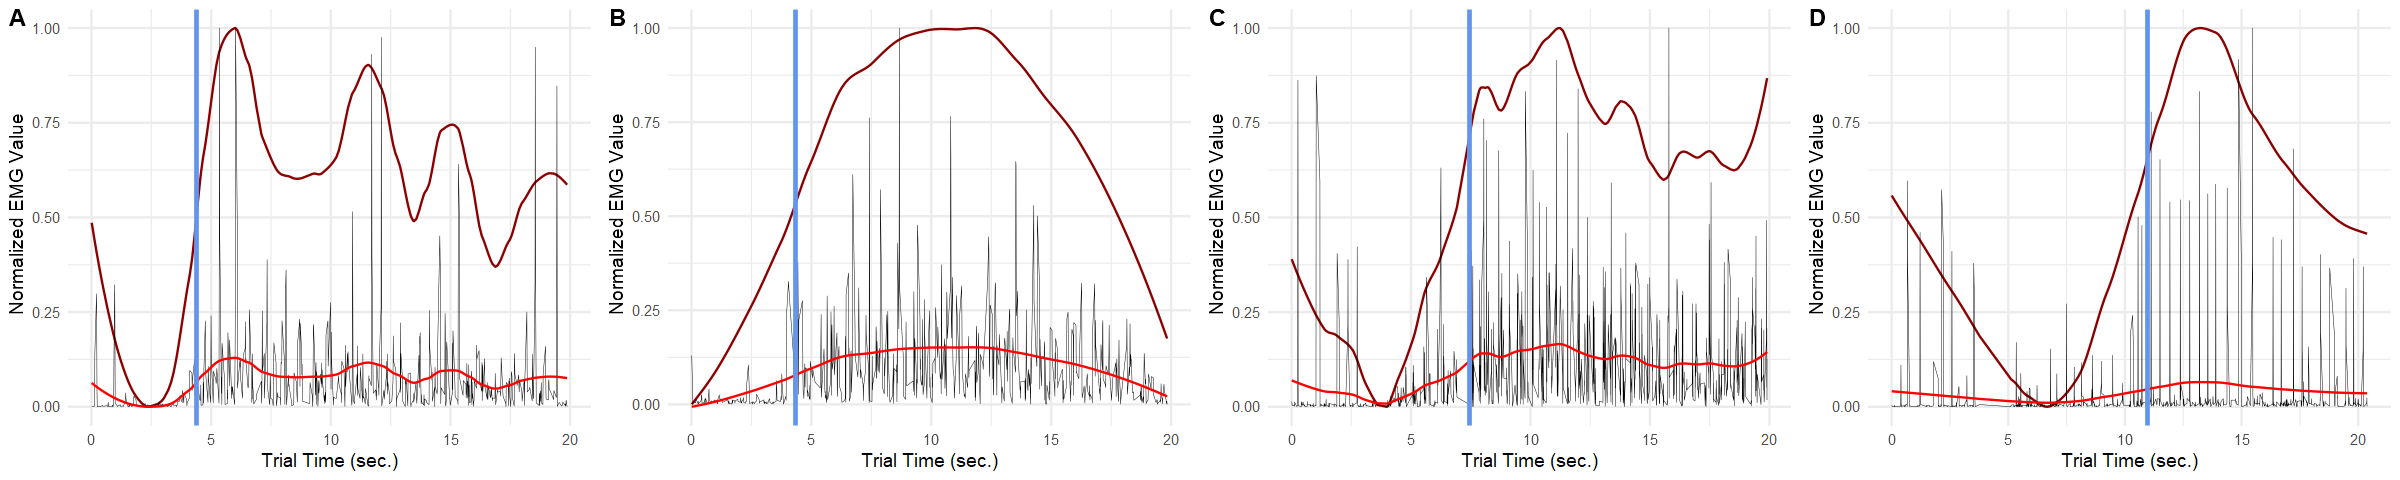

In [8]:
dataTrial <- "1"
dataModality <- "EMS"
dataTiming <- "11"
dataSubjectID <- "108"
dataMuscle <- "biceps"

plotA <- ggplot(data[data$SubjectID == dataSubjectID & data$Muscle == dataMuscle & data$Modality == dataModality & data$Timing == dataTiming & data$Trial == dataTrial,],
               aes(x=trialTime, y=EMGSmoothedValueNormalized)) + geom_line(color="darkred") + 
               geom_line(aes(y=EMGTKEOValueNormalized), size = 0.1)  + geom_line(aes(y=EMGSmoothedValue), color="red") +
               scale_color_manual(values = cbPalette) +
               xlab("Trial Time (sec.)") + 
               ylab("Normalized EMG Value") + 
               geom_vline(data=timesPerSubjectWithTimings[timesPerSubjectWithTimings$SubjectID == dataSubjectID &
                                                          timesPerSubjectWithTimings$Muscle == dataMuscle & 
                                                          timesPerSubjectWithTimings$Modality == dataModality&
                                                          timesPerSubjectWithTimings$Trial == dataTrial & 
                                                          timesPerSubjectWithTimings$Timing == dataTiming,], size = 1, mapping=aes(xintercept=ipbede), color="cornflowerblue")  +
               theme_minimal()
dataTrial <- "2"
dataModality <- "nothing"
dataTiming <- "11"
dataSubjectID <- "182"
dataMuscle <- "calf"

plotB <- ggplot(data[data$SubjectID == dataSubjectID & data$Muscle == dataMuscle & data$Modality == dataModality & data$Timing == dataTiming & data$Trial == dataTrial,],
               aes(x=trialTime, y=EMGSmoothedValueNormalized)) + geom_line(color="darkred") + 
               geom_line(aes(y=EMGTKEOValueNormalized), size = 0.1)  + geom_line(aes(y=EMGSmoothedValue), color="red") +
               scale_color_manual(values = cbPalette) +
               xlab("Trial Time (sec.)") + 
               ylab("Normalized EMG Value") + 
               geom_vline(data=timesPerSubjectWithTimings[timesPerSubjectWithTimings$SubjectID == dataSubjectID &
                                                          timesPerSubjectWithTimings$Muscle == dataMuscle & 
                                                          timesPerSubjectWithTimings$Modality == dataModality&
                                                          timesPerSubjectWithTimings$Trial == dataTrial & 
                                                          timesPerSubjectWithTimings$Timing == dataTiming,], size = 1, mapping=aes(xintercept=ipbede), color="cornflowerblue")   +
               theme_minimal()


dataTrial <- "2"
dataModality <- "Vibration"
dataTiming <- "5"
dataSubjectID <- "191"
dataMuscle <- "triceps"

plotC <- ggplot(data[data$SubjectID == dataSubjectID & data$Muscle == dataMuscle & data$Modality == dataModality & data$Timing == dataTiming & data$Trial == dataTrial,],
               aes(x=trialTime, y=EMGSmoothedValueNormalized)) + geom_line(color="darkred") + 
               geom_line(aes(y=EMGTKEOValueNormalized), size = 0.1)  + geom_line(aes(y=EMGSmoothedValue), color="red") +
               scale_color_manual(values = cbPalette) +
               xlab("Trial Time (sec.)") + 
               ylab("Normalized EMG Value") + 
               geom_vline(data=timesPerSubjectWithTimings[timesPerSubjectWithTimings$SubjectID == dataSubjectID &
                                                          timesPerSubjectWithTimings$Muscle == dataMuscle & 
                                                          timesPerSubjectWithTimings$Modality == dataModality&
                                                          timesPerSubjectWithTimings$Trial == dataTrial & 
                                                          timesPerSubjectWithTimings$Timing == dataTiming,], size = 1, mapping=aes(xintercept=ipbede), color="cornflowerblue")   +
               theme_minimal()


dataTrial <- "1"
dataModality <- "Visual"
dataTiming <- "11"
dataSubjectID <- "190"
dataMuscle <- "calf"

plotD <- ggplot(data[data$SubjectID == dataSubjectID & data$Muscle == dataMuscle & data$Modality == dataModality & data$Timing == dataTiming & data$Trial == dataTrial,],
               aes(x=trialTime, y=EMGSmoothedValueNormalized)) + geom_line(color="darkred") + 
               geom_line(aes(y=EMGTKEOValueNormalized), size = 0.1, color="black")  + geom_line(aes(y=EMGSmoothedValue), color="red") +
               scale_color_manual(values = cbPalette) +
               xlab("Trial Time (sec.)") + 
               ylab("Normalized EMG Value") +   
               geom_vline(data=timesPerSubjectWithTimings[timesPerSubjectWithTimings$SubjectID == dataSubjectID &
                                                          timesPerSubjectWithTimings$Muscle == dataMuscle & 
                                                          timesPerSubjectWithTimings$Modality == dataModality&
                                                          timesPerSubjectWithTimings$Trial == dataTrial & 
                                                          timesPerSubjectWithTimings$Timing == dataTiming,], size = 1, mapping=aes(xintercept=ipbede), color="cornflowerblue") +
               theme_minimal()

options(repr.plot.width = 20, repr.plot.height = 4) 
plot <- ggarrange(plotA, plotB, plotC, plotD,
          labels = c("A", "B", "C", "D"),
          ncol = 4, nrow = 1)
plot
ggsave("ExamplesTKEOandBEDE.pdf", plot, width=14, height=3.5, device=cairo_pdf)

Muscle,Modality,ReactionTime,ReactionTimeCI,ReactionTimeMin,ReactionTimeMinCI,ReactionTimeMax,ReactionTimeMaxCI,N
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
biceps,EMS,9.043282,0.9838099,5.715536,1.0606567,12.77192,1.1845039,16
biceps,nothing,9.551037,0.6680228,6.248156,0.8531904,13.66148,1.3148154,16
biceps,Vibration,8.793655,0.5577294,4.652672,0.6696016,13.11629,1.3019291,16
biceps,Visual,9.318121,0.9024519,6.159440,0.7784254,13.41328,1.5100564,16
calf,EMS,7.711492,0.8309862,4.446944,0.6171252,12.78344,1.3168645,16
calf,nothing,8.831076,0.9755612,5.568712,0.8077473,13.13169,1.5020394,16
calf,Vibration,7.665328,0.8821314,4.830924,0.7935037,11.86882,1.4562635,16
calf,Visual,7.272337,0.8219604,4.620680,0.7219771,11.12863,1.2238032,16
triceps,EMS,8.588431,0.9515662,5.177048,0.8885598,12.61491,1.5311472,16


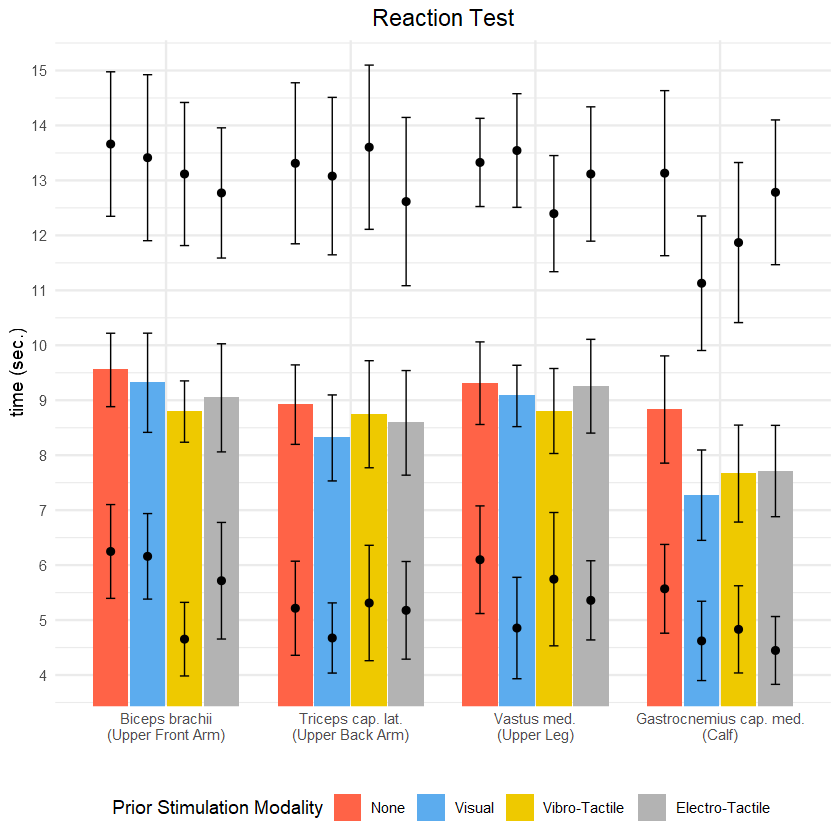

In [9]:
means <- timesPerSubject %>% group_by(Muscle, Modality) %>% 
    summarize(ReactionTime = mean(RT),
              ReactionTimeCI = qt(1 - (0.05 / 2), df = n()-1) * sd(RT) / sqrt(n()), 
              ReactionTimeMin = mean(RTmin),
              ReactionTimeMinCI = qt(1 - (0.05 / 2), df = n()-1) * sd(RTmin) / sqrt(n()), 
              ReactionTimeMax = mean(RTmax),
              ReactionTimeMaxCI = qt(1 - (0.05 / 2), df = n()-1) * sd(RTmax) / sqrt(n()), 
              N = n(),
              .groups = 'drop')  

means

means$Modality <- factor(means$Modality, levels = c("nothing", "Visual", "Vibration", "EMS"))
means$Muscle <- factor(means$Muscle, levels = c("biceps", "triceps", "upperleg", "calf"))

means$Modality <- recode(means$Modality, nothing = "None",
                                         Visual = "Visual",
                                         Vibration = "Vibro-Tactile",
                                         EMS = "Electro-Tactile")

means$Muscle <- recode(means$Muscle, biceps = "Biceps brachii\n(Upper Front Arm)", 
                                     triceps = "Triceps cap. lat.\n(Upper Back Arm)",
                                     upperleg = "Vastus med.\n(Upper Leg)",
                                     calf = "Gastrocnemius cap. med.\n(Calf)") 

plot <- ggplot(means, aes(y=ReactionTime, x=Muscle, fill=Modality)) +  
                        geom_bar(stat = "identity", position = position_dodge(width = 0.8), width=0.75) + 
                        geom_errorbar(aes(ymin = ReactionTime - ReactionTimeCI, ymax = ReactionTime + ReactionTimeCI),
                                      width=.2, position = position_dodge(width = 0.8), size = 0.3) + 
                        scale_y_continuous(breaks = scales::breaks_width(1)) +
                        coord_cartesian(ylim=c(4,15)) +  
                        geom_point(aes(y=ReactionTimeMin, x=Muscle), position = position_dodge(width = 0.8), show.legend = FALSE) + 
                        geom_errorbar(aes(ymin = ReactionTimeMin - ReactionTimeMinCI, ymax = ReactionTimeMin + ReactionTimeMinCI),
                                      width=.2, position = position_dodge(width = 0.8), size = 0.3) + 
                        geom_point(aes(y=ReactionTimeMax, x=Muscle), position = position_dodge(width = 0.8), show.legend = FALSE) + 
                        geom_errorbar(aes(ymin = ReactionTimeMax - ReactionTimeMaxCI, ymax = ReactionTimeMax + ReactionTimeMaxCI),
                                      width=.2, position = position_dodge(width = 0.8), size = 0.3) + 
                        ggtitle("Reaction Test") + 
                        ylab("time (sec.)") + 
                        xlab("") +  
                        labs(fill="Prior Stimulation Modality   ", shape = NULL) +
                        theme_minimal()  + 
                       # geom_signif(comparisons=list(c("True", "False")), annotations="p = 0.033", y_position = 6.75, tip_length = 0.1, vjust=-0.6) +
                        scale_fill_manual(values = cbPalette) +
                        theme(
                            plot.title = element_text(hjust = 0.5),
                            legend.position="bottom"
                        )
                                         
options(repr.plot.width = 7, repr.plot.height = 7) 
plot

ggsave("ReactionTimes.pdf", plot, width=7, height=7, device=cairo_pdf)

In [10]:
aov <- anova_test(data = timesPerSubject, dv = RT, wid = SubjectID, within = c(Muscle, Modality), effect.size = "pes")
get_anova_table(aov, correction = "auto") 

,Effect,DFn,DFd,F,p,p<.05,pes
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Muscle,3,45,6.018,0.002,*,0.286
2,Modality,3,45,5.283,0.003,*,0.260
3,Muscle:Modality,9,135,1.079,0.382,,0.067


In [11]:
aov <- anova_test(data = timesPerSubject, dv = RTmin, wid = SubjectID, within = c(Muscle, Modality), effect.size = "pes")
get_anova_table(aov, correction = "auto") 

,Effect,DFn,DFd,F,p,p<.05,pes
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Muscle,3,45,2.265,0.094,,0.131
2,Modality,3,45,3.707,0.018,*,0.198
3,Muscle:Modality,9,135,1.919,0.054,,0.113


In [12]:
aov <- anova_test(data = timesPerSubject, dv = RTmax, wid = SubjectID, within = c(Muscle, Modality), effect.size = "pes")
get_anova_table(aov, correction = "auto") 

,Effect,DFn,DFd,F,p,p<.05,pes
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Muscle,3,45,1.981,0.130,,0.117
2,Modality,3,45,1.029,0.389,,0.064
3,Muscle:Modality,9,135,1.063,0.394,,0.066


In [13]:
pairwise.t.test(timesPerSubject$RT, timesPerSubject$Modality, p.adj = "bonf", paired = TRUE)
pairwise.t.test(timesPerSubject$RT, timesPerSubject$Muscle, p.adj = "bonf", paired = TRUE)


	Pairwise comparisons using paired t tests 

data:  timesPerSubject$RT and timesPerSubject$Modality 

          EMS   nothing Vibration
nothing   0.069 -       -        
Vibration 1.000 0.011   -        
Visual    1.000 0.016   1.000    

P value adjustment method: bonferroni 


	Pairwise comparisons using paired t tests 

data:  timesPerSubject$RT and timesPerSubject$Muscle 

         biceps  calf    triceps
calf     1.4e-05 -       -      
triceps  0.17643 0.01945 -      
upperleg 1.00000 0.00021 0.45007

P value adjustment method: bonferroni 

,trialTimeS,Muscle,Modality,EMGValue,EMGValueNormalized,EMGTKEOValue,EMGTKEOValueNormalized,EMGSmoothedValueNormalized
,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,biceps,EMS,32926.81,0.4632214,27051740,0.02191011,0.2437466
2,2,biceps,EMS,32988.80,0.4862239,43454786,0.03471080,0.2145658
3,3,biceps,EMS,33001.13,0.4851809,53031462,0.04318428,0.2094902
4,4,biceps,EMS,32853.02,0.4900547,37079159,0.03203180,0.2286508
5,5,biceps,EMS,32966.27,0.4932247,38515894,0.03405701,0.2440095
6,6,biceps,EMS,32871.78,0.4980364,17191867,0.01638028,0.2378166


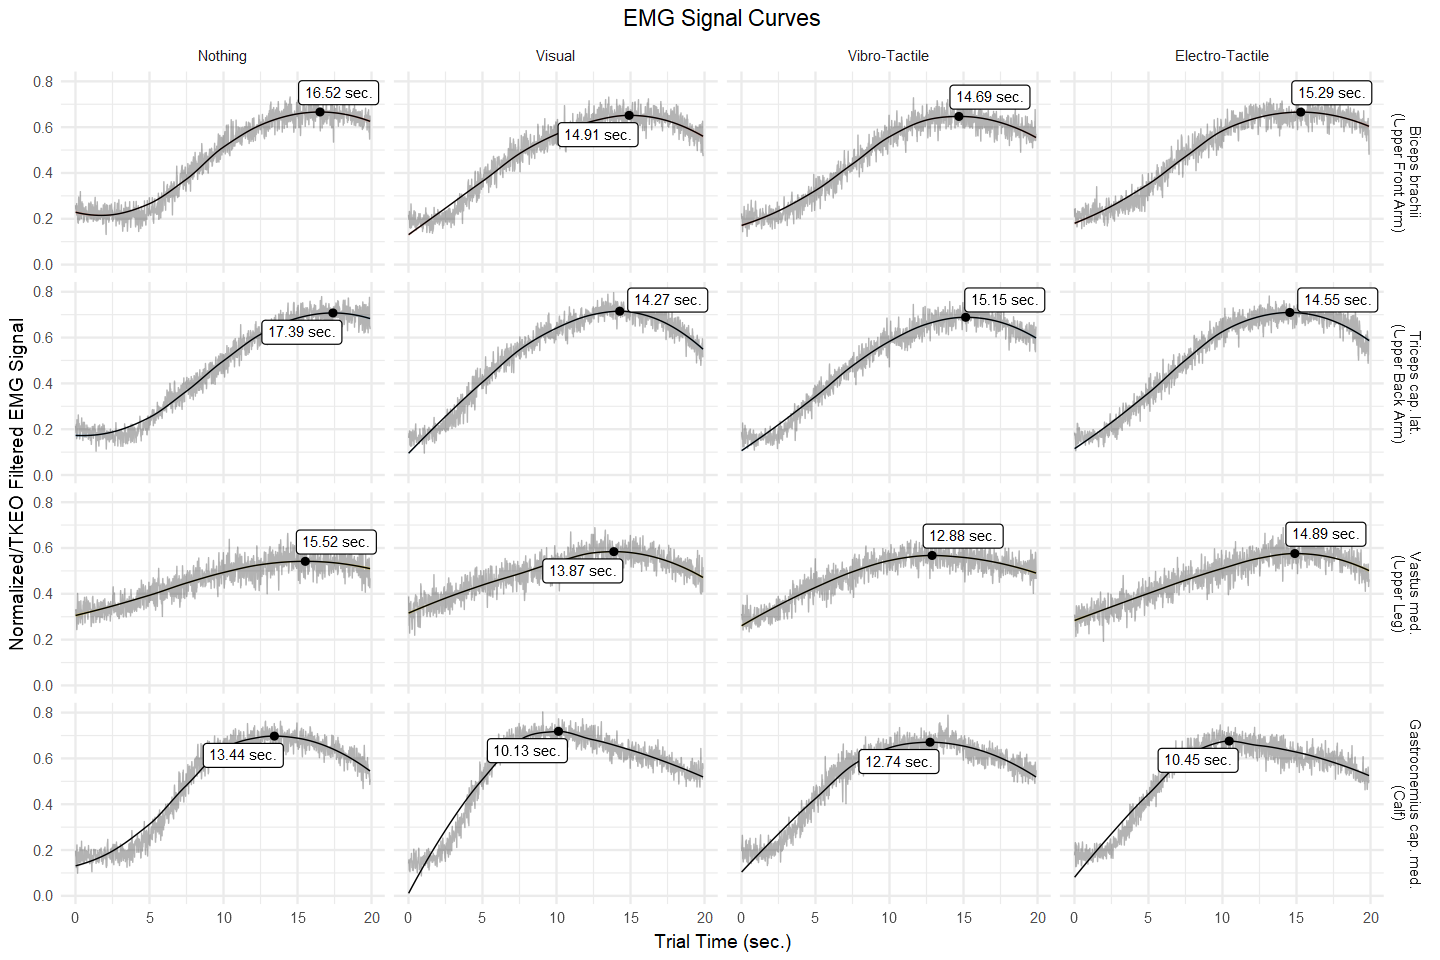

In [14]:
# the world is not enough, we need precise inflections points

inflectionPoint <- function(x, y) {
    xl <- seq(min(x), max(x), (max(x) - min(x)) / 1000)
    suppressWarnings( out <- predict(loess(y~x), xl))
    infl <- c(FALSE, diff(diff(out)>0) != 0)
    c(tail(xl[infl], n=1), tail(out[infl], n = 1))
}   
 
data$trialTimeS <- round(data$trialTime, 2) 

meanData <- aggregate(cbind(EMGValue, EMGValueNormalized, EMGTKEOValue, EMGTKEOValueNormalized, EMGSmoothedValueNormalized) ~ as.factor(trialTimeS) + Muscle + Modality, data[(data$trialTimeS) < 19.9, ], mean)
colnames(meanData) <- c("trialTimeS", "Muscle","Modality", "EMGValue", "EMGValueNormalized", "EMGTKEOValue", "EMGTKEOValueNormalized", "EMGSmoothedValueNormalized")
meanData$trialTimeS <- as.numeric(meanData$trialTimeS)
#head(data)
head(meanData)

df <- meanData %>% group_by(Muscle, Modality) %>% mutate(x1 = inflectionPoint(trialTimeS, EMGSmoothedValueNormalized)[1],
                                                         x2 = inflectionPoint(trialTimeS, EMGSmoothedValueNormalized)[2])
df <- aggregate(cbind(df$x1, df$x2), by=list(df$Muscle, df$Modality), mean)

df <- do.call(data.frame, df)
colnames(df) <- c("Muscle", "Modality", "trialTimeS", "EMGSmoothedValueNormalized") 

df$Modality <- factor(df$Modality, levels = c("nothing", "Visual", "Vibration", "EMS"))
df$Muscle <- factor(df$Muscle, levels = c("biceps", "triceps", "upperleg", "calf")) 

df$Modality <- recode(df$Modality, nothing = "Nothing",
                                         Visual = "Visual",
                                         Vibration = "Vibro-Tactile",
                                         EMS = "Electro-Tactile")

df$Muscle <- recode(df$Muscle, biceps = "Biceps brachii\n(Upper Front Arm)", 
                                     triceps = "Triceps cap. lat.\n(Upper Back Arm)",
                                     upperleg = "Vastus med.\n(Upper Leg)",
                                     calf = "Gastrocnemius cap. med.\n(Calf)") 

meanData$Modality <- factor(meanData$Modality, levels = c("nothing", "Visual", "Vibration", "EMS"))
meanData$Muscle <- factor(meanData$Muscle, levels = c("biceps", "triceps", "upperleg", "calf")) 

meanData$Modality <- recode(meanData$Modality, nothing = "Nothing",
                                         Visual = "Visual",
                                         Vibration = "Vibro-Tactile",
                                         EMS = "Electro-Tactile")

meanData$Muscle <- recode(meanData$Muscle, biceps = "Biceps brachii\n(Upper Front Arm)", 
                                     triceps = "Triceps cap. lat.\n(Upper Back Arm)",
                                     upperleg = "Vastus med.\n(Upper Leg)",
                                     calf = "Gastrocnemius cap. med.\n(Calf)") 

# beautiful TKEO corrected sample 
plot <- ggplot(meanData, aes(x = trialTimeS/ 100, y = EMGSmoothedValueNormalized, color = Muscle, fill = Muscle)) +  
            facet_grid(Muscle ~ Modality) + 
            #geom_errorbar(aes(ymin = mean, ymax = mean), width=0, alpha=0.5, size=0.5) +  
            #scale_x_continuous(breaks = scales::breaks_width(5)) +
            #coord_cartesian(xlim = c(0, 20), expand = FALSE) + 
            #scale_y_continuous(breaks = scales::breaks_width(0.1), limits=c(0,0.3)) +
            geom_line(size = 0.3, alpha = .3, color = "black") + 
            geom_smooth(data = meanData, size = 0.3, method = 'loess', formula = "y ~ x", color = "black") +
            #geom_smooth() +
            geom_point(data = df, color = "black") + 
            ggtitle("EMG Signal Curves") + 
            #ggtitle("GSR Signal Stress Test") +
            #geom_wrap(.~Muscle) + 
            geom_label_repel(data = df, label = paste("",round(df$trialTimeS/ 100, 2),"~sec."), fill="white", color = "black", size=3, show.legend = FALSE, parse = TRUE) + #, "plain('sec')~italic('|')", round(df$EMGSmoothedValueNormalized, 2), " max.", sep="~"
            ylab("Normalized/TKEO Filtered EMG Signal") + 
            #geom_point(data = peaks, aes(x=pos/10,y=val, color="blue"))+
            xlab("Trial Time (sec.)") +  
            scale_color_manual(values = cbPalette) +
            scale_fill_manual(values = cbPalette) +
            theme_minimal() + 
            theme(
                plot.title = element_text(hjust = 0.5),
                legend.position = "none"
            ) 
options(repr.plot.width = 12, repr.plot.height = 8) 
plot
ggsave("ReactionCurves.pdf", plot, width=12, height=8, device=cairo_pdf)

[1] "ANOVA on EMG Amplitude with Experiment Time as Continous Factor"



Error: SubjectID
                              Df    Sum Sq   Mean Sq F value   Pr(>F)    
as.numeric(trialTimeS)         1 1.450e+08 1.450e+08   5.566    0.046 *  
Muscle                         3 4.342e+09 1.447e+09  55.533 1.06e-05 ***
as.numeric(trialTimeS):Muscle  3 4.839e+07 1.613e+07   0.619    0.622    
Residuals                      8 2.085e+08 2.606e+07                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Error: Within
                                   Df    Sum Sq   Mean Sq F value   Pr(>F)    
as.numeric(trialTimeS)              1 1.977e+08 1.977e+08   27.40 1.65e-07 ***
Muscle                              3 1.047e+10 3.489e+09  483.58  < 2e-16 ***
as.numeric(trialTimeS):Muscle       3 6.290e+08 2.097e+08   29.06  < 2e-16 ***
Residuals                     2785462 2.009e+13 7.214e+06                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

[1] "ANOVA on EMG Amplitude with Experiment Time as Discrete Factor"



Error: SubjectID
                  Df    Sum Sq   Mean Sq F value   Pr(>F)    
trialTimeS         1 1.450e+08 1.450e+08   5.566    0.046 *  
Muscle             3 4.342e+09 1.447e+09  55.533 1.06e-05 ***
trialTimeS:Muscle  3 4.839e+07 1.613e+07   0.619    0.622    
Residuals          8 2.085e+08 2.606e+07                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Error: Within
                       Df    Sum Sq   Mean Sq F value   Pr(>F)    
trialTimeS              1 1.977e+08 1.977e+08   27.40 1.65e-07 ***
Muscle                  3 1.047e+10 3.489e+09  483.58  < 2e-16 ***
trialTimeS:Muscle       3 6.290e+08 2.097e+08   29.06  < 2e-16 ***
Residuals         2785462 2.009e+13 7.214e+06                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

,trialTimeS,Muscle,Modality,EMGValue,EMGValueNormalized,EMGTKEOValue,EMGTKEOValueNormalized,EMGSmoothedValueNormalized
,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,biceps,EMS,32870.60,0.5635576,32446973,0.03103170,0.4741693
2,2,biceps,EMS,32840.05,0.4486222,144003733,0.07642887,0.5638610
3,3,biceps,EMS,32824.88,0.4865579,95591306,0.05591267,0.4394936
4,4,biceps,EMS,32859.47,0.4693517,49491393,0.05565530,0.4572505
5,5,biceps,EMS,32867.43,0.5640500,53895107,0.05520218,0.4901512
6,6,biceps,EMS,32846.77,0.4925021,67632518,0.05916619,0.5213304


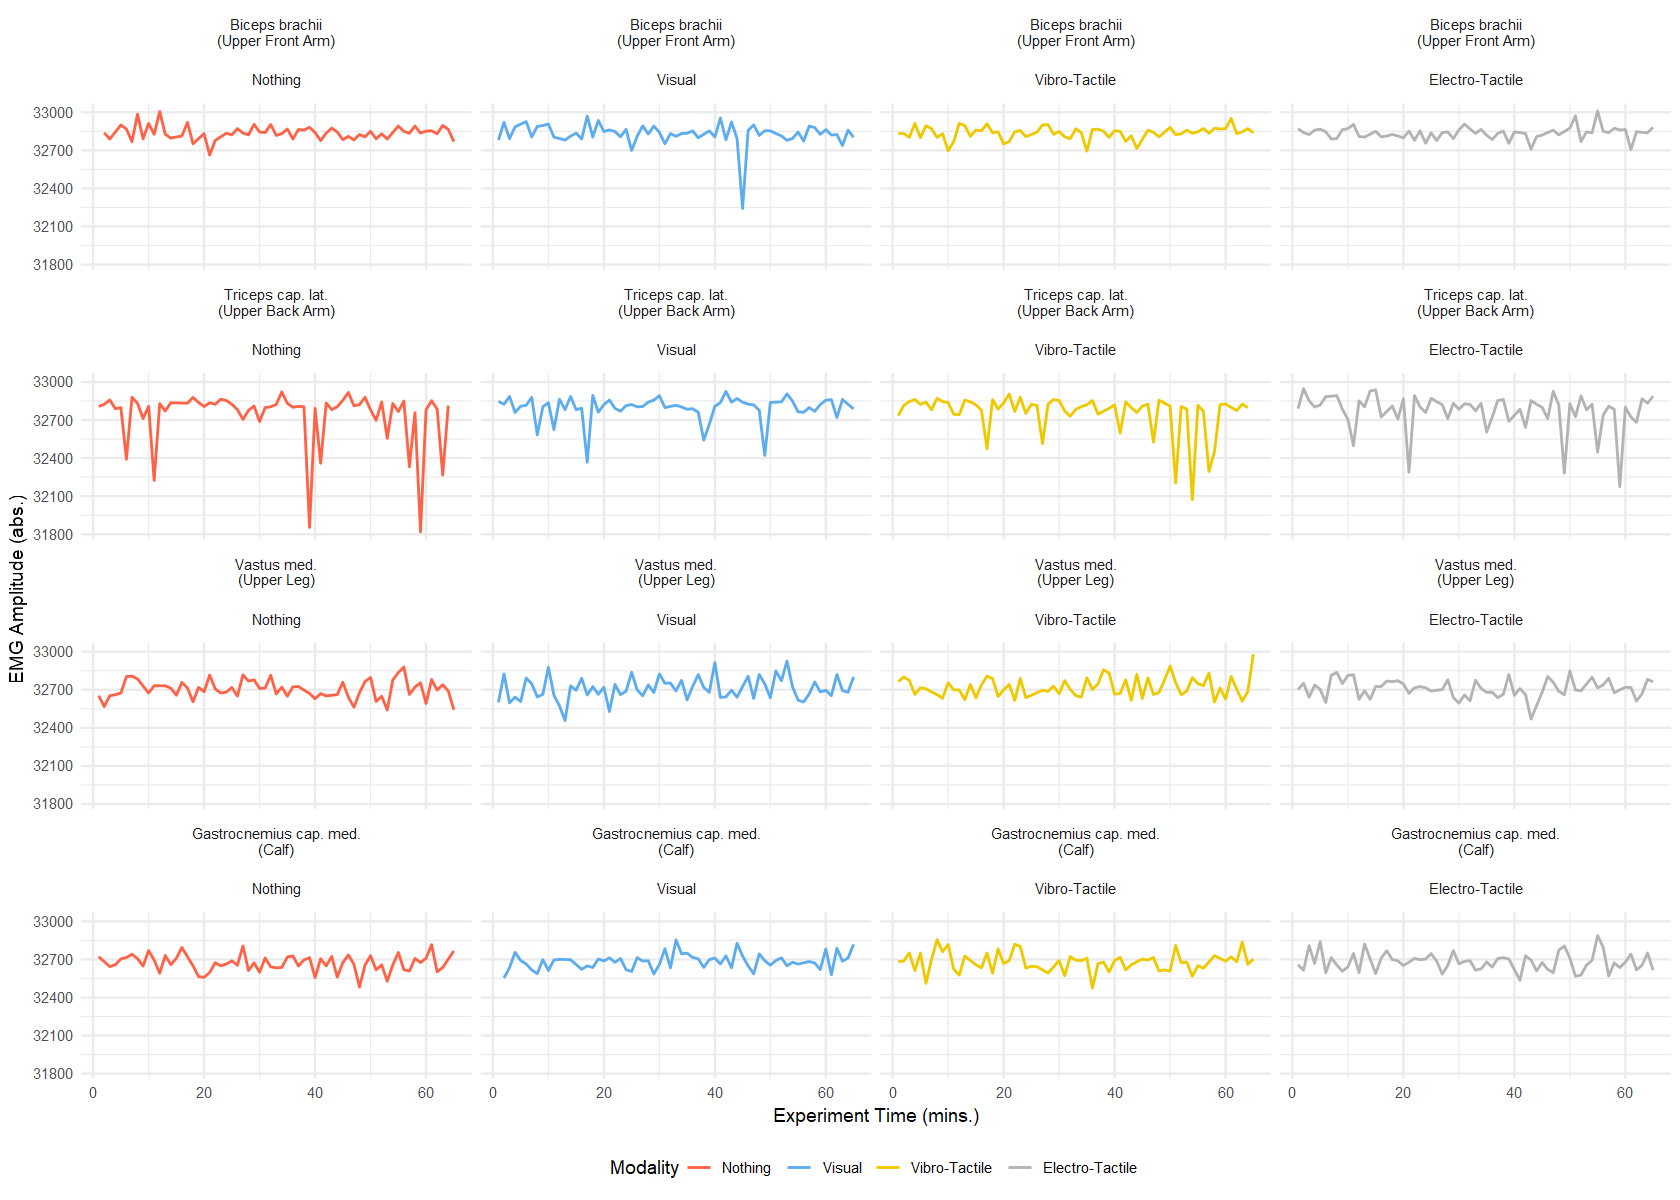

In [15]:
# Does Amplitude change over time?

data$trialTimeS <- round(data$experimentTime/1000/60, 2) 

meanData <- aggregate(cbind(EMGValue, EMGValueNormalized, EMGTKEOValue, EMGTKEOValueNormalized, EMGSmoothedValueNormalized) ~ as.factor(trialTimeS) + Muscle + Modality, data, mean)
colnames(meanData) <- c("trialTimeS", "Muscle","Modality", "EMGValue", "EMGValueNormalized", "EMGTKEOValue", "EMGTKEOValueNormalized", "EMGSmoothedValueNormalized")
meanData$trialTimeS <- as.numeric(meanData$trialTimeS)

#lm <- lm(EMGValue ~ as.numeric(trialTimeS) + Muscle , meanData)
#summary(lm)

print("ANOVA on EMG Amplitude with Experiment Time as Continous Factor")
aov <- aov(EMGValue ~ as.numeric(trialTimeS) * Muscle + Error(SubjectID), data)
summary(aov)

print("ANOVA on EMG Amplitude with Experiment Time as Discrete Factor")
aov <- aov(EMGValue ~ trialTimeS * Muscle + Error(SubjectID), data)
summary(aov)

head(meanData)

meanData$Modality <- factor(meanData$Modality, levels = c("nothing", "Visual", "Vibration", "EMS"))
meanData$Muscle <- factor(meanData$Muscle, levels = c("biceps", "triceps", "upperleg", "calf"))



meanData$Modality <- recode(meanData$Modality, nothing = "Nothing",
                                         Visual = "Visual",
                                         Vibration = "Vibro-Tactile",
                                         EMS = "Electro-Tactile")

meanData$Muscle <- recode(meanData$Muscle, biceps = "Biceps brachii\n(Upper Front Arm)", 
                                     triceps = "Triceps cap. lat.\n(Upper Back Arm)",
                                     upperleg = "Vastus med.\n(Upper Leg)",
                                     calf = "Gastrocnemius cap. med.\n(Calf)") 

# beautiful TKEO corrected sample 
plot <- ggplot(meanData , aes(x = trialTimeS, y = EMGValue, color = Modality, group = Muscle)) +  
            facet_wrap(. ~ Muscle + Modality) + 
            #geom_errorbar(aes(ymin = mean, ymax = mean), width=0, alpha=0.5, size=0.5) +  
           # scale_x_continuous(breaks = scales::breaks_width(5), limits=c(0,20)) +
            #coord_cartesian(ylim = c(0, 0.2), expand = FALSE) + 
            #scale_y_continuous(breaks = scales::breaks_width(0.1), limits=c(0,0.3)) +
            geom_line(size = 0.6) + 
            #geom_smooth(size = 0.3, method = 'loess') +
            #geom_smooth() +
            #ggtitle("GSR Signal Stress Test") +
            #geom_wrap(.~Muscle) + 
            ylab("EMG Amplitude (abs.)") + 
            #geom_point(data = peaks, aes(x=pos/10,y=val, color="blue"))+
            xlab("Experiment Time (mins.)") + 
            #labs(color="Task", linetype="Room") + 
            scale_color_manual(values = cbPalette) +
            theme_minimal() + 
            theme(
                plot.title = element_text(hjust = 0.5),
                legend.position = "bottom"
            ) 
options(repr.plot.width = 14, repr.plot.height = 10) 
plot

# No

SubjectID,Muscle,Modality,Timing,Trial,ReactionTime,ExperimentTime
<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>
106,biceps,EMS,11,1,11.215680,35069.094
106,biceps,EMS,13,1,9.102784,34288.802
106,biceps,EMS,13,2,12.515392,19684.929
106,biceps,EMS,3,1,11.854016,1580.191
106,biceps,EMS,5,1,8.174464,14203.517
106,biceps,EMS,7,1,6.765120,25426.445


SubjectID,Muscle,Modality,Timing,Trial,ReactionTime,ExperimentTime,ExperimentTimeFct
<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>
106,biceps,EMS,11,1,11.215680,35069.094,6
106,biceps,EMS,13,1,9.102784,34288.802,6
106,biceps,EMS,13,2,12.515392,19684.929,3
106,biceps,EMS,3,1,11.854016,1580.191,0
106,biceps,EMS,5,1,8.174464,14203.517,2
106,biceps,EMS,7,1,6.765120,25426.445,4


[1] "ANOVA on Reaction Time with Experiment Time as Discrete Factor"



Error: SubjectID
                         Df Sum Sq Mean Sq
ExperimentTimeFct         6  828.2  138.04
Muscle                    3  119.4   39.81
ExperimentTimeFct:Muscle  6  250.6   41.77

Error: SubjectID:ExperimentTimeFct
                         Df Sum Sq Mean Sq F value Pr(>F)
ExperimentTimeFct         6   37.2   6.194   0.517  0.794
Muscle                    3   14.3   4.776   0.398  0.755
ExperimentTimeFct:Muscle 18  124.7   6.929   0.578  0.904
Residuals                69  827.3  11.990               

Error: SubjectID:Muscle
                         Df Sum Sq Mean Sq F value   Pr(>F)    
Muscle                    3  516.7  172.24    7.35 0.000939 ***
ExperimentTimeFct:Muscle 18  506.2   28.12    1.20 0.326199    
Residuals                27  632.7   23.43                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Error: Within
                           Df Sum Sq Mean Sq F value Pr(>F)
ExperimentTimeFct:Muscle   18    106   5.877    0.69  0.824
R

[1] " "
[1] "ANOVA on Reaction Time with Experiment Time as Continous Factor"



Error: SubjectID
                      Df Sum Sq Mean Sq F value  Pr(>F)   
ExperimentTime         1  544.0   544.0  12.519 0.00764 **
Muscle                 3  240.1    80.0   1.842 0.21778   
ExperimentTime:Muscle  3   66.5    22.2   0.510 0.68656   
Residuals              8  347.7    43.5                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Error: SubjectID:ExperimentTime
                      Df Sum Sq Mean Sq F value Pr(>F)
ExperimentTime         1   8.78   8.780   1.233  0.296
Muscle                 3   8.84   2.947   0.414  0.747
ExperimentTime:Muscle  3  51.01  17.003   2.387  0.137
Residuals              9  64.10   7.123               

Error: SubjectID:Muscle
                      Df Sum Sq Mean Sq F value  Pr(>F)   
Muscle                 3  517.3  172.43   6.182 0.00141 **
ExperimentTime:Muscle  3   59.5   19.84   0.711 0.55076   
Residuals             42 1171.5   27.89                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.0

Muscle,ExperimentTimeFct,RT,RTCI,ET,N
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<int>
biceps,0,9.108316,1.0257301,1430.729,36
biceps,1,9.471084,0.6743946,6169.238,81
biceps,2,9.170872,0.8716557,12121.084,56
biceps,3,8.959076,0.7167252,17893.975,77
biceps,4,8.610066,0.7343179,24101.303,65
biceps,5,9.160028,0.7739400,30085.802,57


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


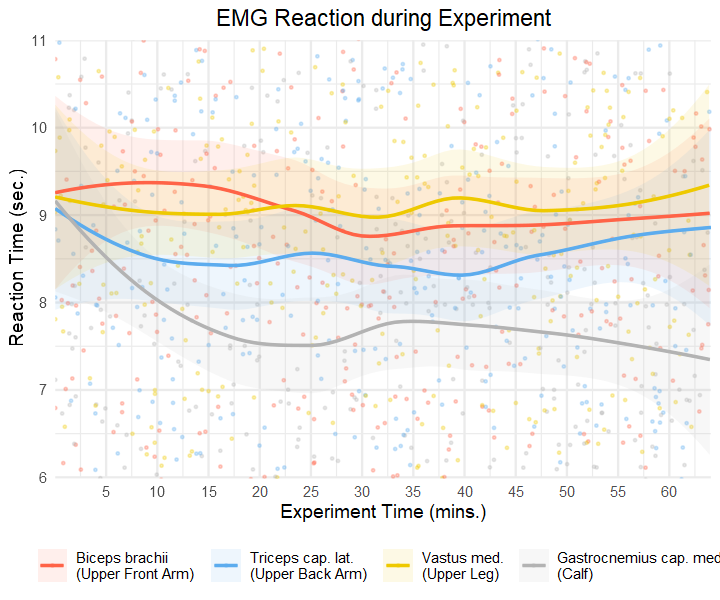

In [16]:
# Does reaction time depends on experimental time and muscle?

findBulgeStart <- function(x, y){
    cc <- check_curve(x, y)
    #ipbese <- bese(x, y, cc$index)
    ipbede <- bede(x, y, cc$index)
    #ipbede <- ifelse(!is.na(ipbede), ipbede, 20)
    return(as.numeric(ipbede$iplast))
}

timePerSubject <- data %>% group_by(SubjectID, Muscle, Modality, Timing, Trial) %>% 
    summarize(ReactionTime = findBulgeStart(trialTime, EMGSmoothedValueNormalized),
              ExperimentTime = max(experimentTime),
              .groups = 'drop')

timePerSubject <- na.omit(timePerSubject) 
head(timePerSubject)
timePerSubject$ExperimentTimeFct <- as.factor(round(timePerSubject$ExperimentTime/ 6000,0))

head(timePerSubject)

print("ANOVA on Reaction Time with Experiment Time as Discrete Factor")
aov <- aov(ReactionTime ~ ExperimentTimeFct * Muscle + Error(SubjectID / (ExperimentTimeFct + Muscle)), timePerSubject)
summary(aov)

print(" ")
print("ANOVA on Reaction Time with Experiment Time as Continous Factor")
aov <- aov(ReactionTime ~ ExperimentTime * Muscle + Error(SubjectID / (ExperimentTime + Muscle)), timePerSubject)
summary(aov) 

means <- timePerSubject %>% group_by(Muscle, ExperimentTimeFct) %>% 
    summarize(RT = mean(ReactionTime),
              RTCI = qt(1 - (0.05 / 2), df = n()-1) * sd(ReactionTime) / sqrt(n()), 
              ET = mean(ExperimentTime),
              N = n(),
              .groups = 'drop')  

means <- na.omit(means) 
head(means)

#means$Modality <- factor(meanData$Modality, levels = c("nothing", "Visual", "Vibration", "EMS"))
timePerSubject$Muscle <- factor(timePerSubject$Muscle, levels = c("biceps", "triceps", "upperleg", "calf"))
means$Muscle <- factor(means$Muscle, levels = c("biceps", "triceps", "upperleg", "calf"))

  
means$Muscle <- recode(means$Muscle, biceps = "Biceps brachii\n(Upper Front Arm)", 
                                     triceps = "Triceps cap. lat.\n(Upper Back Arm)",
                                     upperleg = "Vastus med.\n(Upper Leg)",
                                     calf = "Gastrocnemius cap. med.\n(Calf)") 

timePerSubject$Muscle <- recode(timePerSubject$Muscle, biceps = "Biceps brachii\n(Upper Front Arm)", 
                                     triceps = "Triceps cap. lat.\n(Upper Back Arm)",
                                     upperleg = "Vastus med.\n(Upper Leg)",
                                     calf = "Gastrocnemius cap. med.\n(Calf)") 
# beautiful TKEO corrected sample 
plot <- ggplot(timePerSubject, aes(x = ExperimentTime / 600, y = ReactionTime, color = Muscle, fill = Muscle)) +   
            #geom_errorbar(aes(ymin = mean, ymax = mean), width=0, alpha=0.5, size=0.5) +  
            scale_x_continuous(breaks = scales::breaks_width(5)) +
            coord_cartesian(ylim = c(6, 11), expand = FALSE) + 
            #scale_y_continuous(breaks = scales::breaks_width(1), limits=c(6,11)) +
            #geom_line(size = 0.6) + 
            geom_point(alpha = 0.3, size = 0.3) + 
            geom_smooth(method = 'loess', alpha = 0.1, size = 0.5) +
            geom_smooth(method = 'loess', alpha = 1, size = 0.75, se = FALSE) +
            ggtitle("EMG Reaction during Experiment") +
            #geom_wrap(.~Muscle) + 
            labs(fill = "", color = "") +
            ylab("Reaction Time (sec.)") + 
            #geom_point(data = peaks, aes(x=pos/10,y=val, color="blue"))+
            xlab("Experiment Time (mins.)") + 
            #labs(color="Task", linetype="Room") + 
            scale_color_manual(values = cbPalette) +
            scale_fill_manual(values = cbPalette) +
            theme_minimal() + 
            theme(
                plot.title = element_text(hjust = 0.5),
                legend.position = "bottom"
            ) 
options(repr.plot.width = 6, repr.plot.height = 5) 
plot
ggsave("FatigueVSLearning.pdf", plot, width=6, height=5, device=cairo_pdf)

# Muscle

In [ ]:
means <- timePerSubject %>% group_by(Muscle, ExperimentTimeFct) %>% 
    summarize(RT = mean(ReactionTime),
              RTCI = qt(1 - (0.05 / 2), df = n()-1) * sd(ReactionTime) / sqrt(n()), 
              ET = mean(ExperimentTime),
              N = n(),
              .groups = 'drop')  

means <- na.omit(means) 
head(means)

#means$Modality <- factor(meanData$Modality, levels = c("nothing", "Visual", "Vibration", "EMS"))
timePerSubject$Muscle <- factor(timePerSubject$Muscle, levels = c("biceps", "triceps", "upperleg", "calf"))
means$Muscle <- factor(means$Muscle, levels = c("biceps", "triceps", "upperleg", "calf"))

  
means$Muscle <- recode(means$Muscle, biceps = "Biceps brachii\n(Upper Front Arm)", 
                                     triceps = "Triceps cap. lat.\n(Upper Back Arm)",
                                     upperleg = "Vastus med.\n(Upper Leg)",
                                     calf = "Gastrocnemius cap. med.\n(Calf)") 

plot <- ggplot(means, aes(x = ET / 600, y = RT, color = Muscle, fill = Muscle)) +   
            geom_errorbar(aes(ymin = RT - RTCI, ymax = RT + RTCI), width=1, alpha=0.5, size=0.5) +  
            scale_x_continuous(breaks = scales::breaks_width(10)) +
            coord_cartesian(ylim = c(6, 11), expand = FALSE) + 
            #scale_y_continuous(breaks = scales::breaks_width(1), limits=c(6,11)) +
            geom_line() + 
            geom_point() +  
            #ggtitle("GSR Signal Stress Test") +
            #geom_wrap(.~Muscle) + 
            ylab("Reaction Time (sec.)") + 
            #geom_point(data = peaks, aes(x=pos/10,y=val, color="blue"))+
            xlab("Experiment Time (mins.)") + 
            #labs(color="Task", linetype="Room") + 
            scale_color_manual(values = cbPalette) +
            theme_minimal() + 
            labs(fill = "", color = "") +
            theme(
                plot.title = element_text(hjust = 0.5),
                legend.position = "bottom"
            ) 
options(repr.plot.width = 6, repr.plot.height = 4) 
plot